In [2]:
# Install scikit-multilearn, a library for multi-label classification
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 4.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, hamming_loss, zero_one_loss, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

## Data exploration

The given datasets were combined together to create a joined dataset which is imported into this notebook.

In [4]:
# Read the joined dataset
df = pd.read_csv('combined_df.csv')
df

,POLICY_NUMBER,START_DATE,END_DATE,POLICY_STATUS,PREMIUM,NUMBER_OF_DRIVERS,PAYMENTMETHOD,VEHICLE_ID,CUSTOMER_ID,MARITALSTATUS,...,CLAIM_ID,INCURRED,SEGMENT_1_FLAG,SEGMENT_2_FLAG,SEGMENT_3_FLAG,SEGMENT_4_FLAG,SEGMENT_5_FLAG,SEGMENT_6_FLAG,Age,Age_group
0,6.495726e+09,2021-02-01 00:00:00,2022-01-31 00:00:00,Renewal,370.401518,2.0,NaN,vehicle70018R,customer17135R,Single,...,claim458112,79.462299,NaN,NaN,NaN,NaN,NaN,NaN,28.0,26-35
1,6.495726e+09,2020-02-01,2021-01-31,New Business,369.137312,2.0,NaN,vehicle70018,customer17135,Single,...,claim458112,79.462299,0.0,0.0,0.0,0.0,0.0,0.0,28.0,26-35
2,6.495676e+09,2020-10-17,2021-10-16,New Business,142.969466,2.0,NaN,vehicle37044,customer115167,Married,...,claim361411,89.241458,0.0,0.0,0.0,0.0,0.0,0.0,61.0,56-65
3,6.495813e+09,2020-06-11,2021-06-10,New Business,244.005751,1.0,NaN,vehicle197044,customer171987,Single,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,34.0,26-35
4,6.495567e+09,2020-06-15 00:00:00,2021-06-14 00:00:00,Renewal,412.400710,2.0,NaN,vehicle39531R,customer79839R,CommonLaw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90195,6.495733e+09,2020-02-06,2021-02-05,New Business,126.539718,2.0,NaN,vehicle62048,customer273560,Married,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,41.0,36-45
90196,6.495345e+09,2018-10-20,2019-10-19,New Business,171.775478,2.0,NaN,vehicle96992,customer242805,CommonLaw,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,50.0,46-55
90197,6.495719e+09,2019-12-27,2020-12-26,New Business,275.025662,1.0,NaN,vehicle68360,customer270050,Single,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,31.0,26-35
90198,6.495427e+09,2019-02-22,2020-02-21,New Business,232.072537,1.0,NaN,vehicle186506,customer53930,Married,...,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,50.0,46-55


The data types of each column is checked to get an idea of the numerical and categorical columns present in the data frame.

In [5]:
# Check the data types for each column
df.dtypes

POLICY_NUMBER            float64
START_DATE                object
END_DATE                  object
POLICY_STATUS             object
PREMIUM                  float64
NUMBER_OF_DRIVERS        float64
PAYMENTMETHOD             object
VEHICLE_ID                object
CUSTOMER_ID               object
MARITALSTATUS             object
DATE_OF_BIRTH             object
NCD                      float64
EMPLOYMENTTYPE            object
VEHICLE_CLASSOFUSE        object
VEHICLE_VALUE            float64
VEHICLE_AGE              float64
VEHICLE_ANNUALMILEAGE    float64
VEHICLE_OWNEDMONTHS      float64
DATE_OF_ACCIDENT          object
CLAIM_ID                  object
INCURRED                 float64
SEGMENT_1_FLAG           float64
SEGMENT_2_FLAG           float64
SEGMENT_3_FLAG           float64
SEGMENT_4_FLAG           float64
SEGMENT_5_FLAG           float64
SEGMENT_6_FLAG           float64
Age                      float64
Age_group                 object
dtype: object

Replace empty values with NaNs and check for the percentage of null values in each column.

In [6]:
# Replace empty values (if any) with NaN
df[df.loc[:,:] == ' '] = np.NaN

In [7]:
# Check NaN percentage in each column
df.isna().sum()/len(df) * 100

POLICY_NUMBER             0.000000
START_DATE                0.000000
END_DATE                  0.000000
POLICY_STATUS             0.000000
PREMIUM                   0.106430
NUMBER_OF_DRIVERS         0.113082
PAYMENTMETHOD            67.175166
VEHICLE_ID                0.000000
CUSTOMER_ID               0.000000
MARITALSTATUS             0.074279
DATE_OF_BIRTH             0.032151
NCD                       0.000000
EMPLOYMENTTYPE            0.063193
VEHICLE_CLASSOFUSE        0.000000
VEHICLE_VALUE             0.000000
VEHICLE_AGE               0.000000
VEHICLE_ANNUALMILEAGE     0.000000
VEHICLE_OWNEDMONTHS       0.000000
DATE_OF_ACCIDENT         84.980044
CLAIM_ID                 84.963415
INCURRED                 84.990022
SEGMENT_1_FLAG           17.129712
SEGMENT_2_FLAG           17.184035
SEGMENT_3_FLAG           17.124169
SEGMENT_4_FLAG           17.151885
SEGMENT_5_FLAG           17.174058
SEGMENT_6_FLAG           17.137472
Age                       0.032151
Age_group           

Display a statistical summary of the numerical columns to find outliers.

In [8]:
# Check for numerical columns' descriptions
df.iloc[:,:].describe()

,POLICY_NUMBER,PREMIUM,NUMBER_OF_DRIVERS,NCD,VEHICLE_VALUE,VEHICLE_AGE,VEHICLE_ANNUALMILEAGE,VEHICLE_OWNEDMONTHS,INCURRED,SEGMENT_1_FLAG,SEGMENT_2_FLAG,SEGMENT_3_FLAG,SEGMENT_4_FLAG,SEGMENT_5_FLAG,SEGMENT_6_FLAG,Age
count,9.020000e+04,90104.000000,90098.000000,90200.000000,90200.000000,90200.000000,90200.000000,90200.000000,13539.000000,74749.000000,74700.000000,74754.000000,74729.000000,74709.000000,74742.000000,90171.000000
mean,6.495698e+09,262.944152,1.601046,7.155067,5233.136282,9.796275,7057.624008,50.043348,2130.809081,0.126236,0.036908,0.019103,0.018360,0.051774,0.088531,47.455180
std,1.866327e+05,142.601210,0.606839,2.683235,5018.882563,4.368040,3426.182359,36.441472,6955.893205,0.332117,0.188536,0.136887,0.134249,0.221572,0.284068,14.693523
min,6.495186e+09,28.802259,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-211.627233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
25%,6.495545e+09,163.050237,1.000000,5.000000,1947.561151,7.000000,4985.951079,24.000000,10.015530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000
50%,6.495715e+09,219.813922,2.000000,9.000000,3885.749063,10.000000,6973.253877,41.000000,96.941428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000
75%,6.495843e+09,317.041031,2.000000,9.000000,6985.598131,13.000000,9973.989271,67.000000,2078.086851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000
max,6.496022e+09,2287.951049,7.000000,9.000000,75014.190770,34.000000,128014.035124,322.000000,275280.578552,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000


`VEHICLE_VALUE` and `VEHICLE_ANNUALMILEAGE` seem to have some undesired values.

In [9]:
# Display the 10 smallest values under 'VEHICLE_VALUE'
df['VEHICLE_VALUE'].nsmallest(n=10)

51657     0.000000
71175     0.000000
51656     0.891725
79887     3.052507
78176     9.256327
87718    19.492191
57904    35.456487
57067    46.251744
39363    84.846754
81068    89.450420
Name: VEHICLE_VALUE, dtype: float64

Don't modify `VEHICLE_VALUE` due to lots of smaller, ambiguous numbers.

In [10]:
# Display the 5 smallest values under 'VEHICLE_ANNUALMILEAGE'
df['VEHICLE_ANNUALMILEAGE'].nsmallest()

50609      0.000000
63879    160.654575
8431     181.367348
64393    181.974535
85208    185.719088
Name: VEHICLE_ANNUALMILEAGE, dtype: float64

Remove the distinct, undesired zero value from `VEHICLE_ANNUALMILEAGE`.

In [11]:
# Remove the erroneous index value
df = df.drop(index=50609)

Check for undesired values in the categorical columns.

In [12]:
# Count the values in the categorical columns
print(df['POLICY_STATUS'].value_counts())
print(df['MARITALSTATUS'].value_counts())
print(df['EMPLOYMENTTYPE'].value_counts())
print(df['VEHICLE_CLASSOFUSE'].value_counts())

New Business    72215
Renewal         15425
Cancelled        2559
Name: POLICY_STATUS, dtype: int64
Married        42523
Single         24974
CommonLaw      12739
Divorced        6915
Widowed         2211
Parthership      769
None               1
Name: MARITALSTATUS, dtype: int64
Employed                          64971
Retired                           11386
Self Employed                      7422
Household Duties                   3146
In Full Or Part Time Education     1413
Unemployed                         1146
Not employed due to disability      560
Independent Means                    69
Voluntary Work                       28
Unknown                               1
Name: EMPLOYMENTTYPE, dtype: int64
Social inc. Comm                              46797
Social only                                   34793
Business Use (PH)                              7104
Business use (PH + Spouse / Civil Partner)     1058
Business use by all drivers                     248
Business use (spouse / C

Remove 'None' from `MARITALSTATUS`; 'Unknown' from `EMPLOYMENTTYPE`; 'unk', 'None', & 'Unknown' from `VEHICLE_CLASSOFUSE`.

In [13]:
# Remove low-count categories
df = df.loc[(df['MARITALSTATUS'] != 'None') &
            (df['EMPLOYMENTTYPE'] != 'Unknown') &
            (df['VEHICLE_CLASSOFUSE'] != 'unk') &
            (df['VEHICLE_CLASSOFUSE'] != 'None') &
            (df['VEHICLE_CLASSOFUSE'] != 'Unknown')]

## Data pre-processing

### Data splitting
Split the data into train and test sets using iterative stratification due to multi-label data.

In [14]:
# Divide the dataframe into independent and dependent variables
X = df.drop(df.iloc[:,-8:-2], axis=1)
y = df.iloc[:,-8:-2].fillna(0)

# Split the dataset into train and test sets
X_train, y_train, X_test, y_test = iterative_train_test_split(X.values, y.values, test_size = 0.2)

### Data formatting

`iterative_train_test_split()` returns arrays instead of data frames after splitting. Convert each array back into data frame.

In [15]:
# Extract columns for X and y variables
X_cols = df.drop(columns=df.columns[-8:-2]).columns
y_cols = df.columns[-8:-2]

In [16]:
# Function to convert X variable array to data frame
def arr_to_dfx(arr):
    return (pd.DataFrame(data=arr[0:,0:], index=[i for i in range(arr.shape[0])], columns=[X_cols[i] for i in range(len(X_cols))]))

In [17]:
# Function to convert y variable array to data frame
def arr_to_dfy(arr):
    return (pd.DataFrame(data=arr[0:,0:], index=[i for i in range(arr.shape[0])], columns=[y_cols[i] for i in range(len(y_cols))]))

In [18]:
# Convert arrays to data frames for each variable
X_train = arr_to_dfx(X_train)
y_train = arr_to_dfy(y_train)

X_test = arr_to_dfx(X_test)
y_test = arr_to_dfy(y_test)

### One-hot encoding

Apply one-hot encoder on categorical features. The parameter handle_unknown="ignore" ensures that the model is robust during production as it ignores labels not seen in train set that are present in test set, thus avoiding any interruption during execution.

In [19]:
# Use One-Hot Encoding to perform fitting for categorical features in the train data
ohe = OneHotEncoder(handle_unknown="ignore") # Ensure consistent results on unseen data
ohe.fit(X_train[['POLICY_STATUS', 'MARITALSTATUS', 'EMPLOYMENTTYPE', 'VEHICLE_CLASSOFUSE']])

OneHotEncoder(handle_unknown='ignore')

### Data cleaning

Clean the datasets and apply one-hot encoder to train and test sets.

In [20]:
# Create a function for pre-processing a dataframe
def preprocess(dfr):
    
    dfr[['START_DATE','END_DATE']] = dfr[['START_DATE','END_DATE']].apply(pd.to_datetime) # Convert the dates to datetime format
    dfr['Policy_duration'] = (dfr['END_DATE'] - dfr['START_DATE']).dt.days # Create 'Policy_duration' instead of using start and end dates
    
    subset = dfr[['POLICY_STATUS', 'MARITALSTATUS', 'EMPLOYMENTTYPE', 'VEHICLE_CLASSOFUSE']] # Create a subset of relevant categorical columns

    feature_arr = ohe.transform(subset).toarray() # Transform the dataframe using one-hot encoding
    feature_labels = ohe.get_feature_names_out() # Extract the encoded feature labels

    features = pd.DataFrame(feature_arr, columns=feature_labels, index=subset.index) # Create a dataframe for feature array & labels post-encoding
    dfr = pd.concat([dfr, features], axis=1) # Concat the (now) feature dataframe with the argument dataframe

    dfr = dfr.drop(columns=['START_DATE', 'END_DATE', 'POLICY_NUMBER',
                            'PAYMENTMETHOD', 'VEHICLE_ID', 'CUSTOMER_ID',
                            'DATE_OF_BIRTH', 'DATE_OF_ACCIDENT', 'CLAIM_ID',
                            'INCURRED', 'Age_group', 'POLICY_STATUS',
                            'MARITALSTATUS', 'EMPLOYMENTTYPE', 'VEHICLE_CLASSOFUSE']) # Drop redundant columns
    
    return dfr # Return the pre-processed dataframe

In [21]:
# Encode and pre-process the train set
X_train = preprocess(X_train).astype(float).drop(columns=['MARITALSTATUS_nan', 'EMPLOYMENTTYPE_nan'])
X_train.head()

,PREMIUM,NUMBER_OF_DRIVERS,NCD,VEHICLE_VALUE,VEHICLE_AGE,VEHICLE_ANNUALMILEAGE,VEHICLE_OWNEDMONTHS,Age,Policy_duration,POLICY_STATUS_Cancelled,...,EMPLOYMENTTYPE_Retired,EMPLOYMENTTYPE_Self Employed,EMPLOYMENTTYPE_Unemployed,EMPLOYMENTTYPE_Voluntary Work,VEHICLE_CLASSOFUSE_Business Use (PH),VEHICLE_CLASSOFUSE_Business use (PH + Spouse / Civil Partner),VEHICLE_CLASSOFUSE_Business use (spouse / Civil Parnter),VEHICLE_CLASSOFUSE_Business use by all drivers,VEHICLE_CLASSOFUSE_Social inc. Comm,VEHICLE_CLASSOFUSE_Social only
0,370.401518,2.0,3.0,2776.289729,7.0,16995.324235,75.0,28.0,364.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,369.137312,2.0,2.0,2794.775294,6.0,16987.792596,63.0,28.0,365.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,142.969466,2.0,9.0,2038.564143,13.0,9956.736453,75.0,61.0,364.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,244.005751,1.0,8.0,1982.488540,11.0,10033.574414,25.0,34.0,364.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,412.400710,2.0,7.0,5013.587268,8.0,17972.106978,34.0,31.0,364.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
# Encode and pre-process the test set
X_test = preprocess(X_test).astype(float).drop(columns=['MARITALSTATUS_nan', 'EMPLOYMENTTYPE_nan'])

This procedure efficiently handled NaNs without having to remove all of them individually. Remove null values from the remaining columns.

In [23]:
# Check for null value counts again
X_train.isna().sum()

PREMIUM                                                          78
NUMBER_OF_DRIVERS                                                81
NCD                                                               0
VEHICLE_VALUE                                                     0
VEHICLE_AGE                                                       0
VEHICLE_ANNUALMILEAGE                                             0
VEHICLE_OWNEDMONTHS                                               0
Age                                                              25
Policy_duration                                                   0
POLICY_STATUS_Cancelled                                           0
POLICY_STATUS_New Business                                        0
POLICY_STATUS_Renewal                                             0
MARITALSTATUS_CommonLaw                                           0
MARITALSTATUS_Divorced                                            0
MARITALSTATUS_Married                           

In [24]:
# Drop NAs after join X and y variables for train and test sets separately
train_joined = X_train.join(y_train).dropna()
test_joined = X_test.join(y_test).dropna()

In [25]:
# Split into X and y variables for train and test sets again
X_train = train_joined.iloc[:, :-6]
y_train = train_joined.iloc[:, -6:]

X_test = test_joined.iloc[:, :-6]
y_test = test_joined.iloc[:, -6:]

## Model development

Use `DecisionTreeClassifier()` for modelling.

### Hyper-parameter tuning
Use `RandomizedSearchCV()` with a grid of parameters to find the optimal hyper-parameters for the model. The parameter error_score=0 ensures that fitting during cross-validation is uninterrupted.

In [26]:
# Instantiate Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=18)

# Define a grid of parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [*range(2, 10, 1)],
    'max_leaf_nodes': [*range(1, 100, 2)],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use Randomized Search with 5 fold cross-validation to find optimal hyper-parameters
CV_model_dt = RandomizedSearchCV(estimator=dtc, param_distributions=param_grid, cv=5, error_score=0, verbose=1, random_state=18)
CV_model_dt.fit(X_train, y_train)

# Print the optimal hyperparameters after randomized search cross-validation
print(CV_model_dt.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'splitter': 'best', 'max_leaf_nodes': 37, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}


Display all the fits and the best estimator.

In [27]:
# Display the fits/results from cross validation
pd.DataFrame.from_dict(CV_model_dt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.367681,0.046219,0.028667,0.009176,best,71,auto,5,entropy,"{'splitter': 'best', 'max_leaf_nodes': 71, 'ma...",0.870493,0.869937,0.804071,0.644549,0.557771,0.749364,0.126409,3
1,0.176008,0.016944,0.032131,0.008925,random,71,sqrt,8,entropy,"{'splitter': 'random', 'max_leaf_nodes': 71, '...",0.869728,0.866254,0.800667,0.645453,0.557771,0.747975,0.125123,9
2,0.209871,0.042149,0.031897,0.012441,best,45,log2,5,gini,"{'splitter': 'best', 'max_leaf_nodes': 45, 'ma...",0.870493,0.869937,0.804002,0.644549,0.557771,0.749350,0.126403,7
3,0.187285,0.046654,0.040091,0.015273,random,85,sqrt,3,entropy,"{'splitter': 'random', 'max_leaf_nodes': 85, '...",0.870493,0.869937,0.804071,0.644549,0.557771,0.749364,0.126409,3
4,0.306880,0.105495,0.043266,0.013668,best,27,log2,7,gini,"{'splitter': 'best', 'max_leaf_nodes': 27, 'ma...",0.870493,0.869937,0.804071,0.644549,0.557771,0.749364,0.126409,3
5,0.400188,0.136147,0.051427,0.019754,best,91,sqrt,9,gini,"{'splitter': 'best', 'max_leaf_nodes': 91, 'ma...",0.864517,0.865977,0.802057,0.643785,0.557424,0.746752,0.124571,10
6,0.514779,0.097950,0.036911,0.018234,best,75,sqrt,9,entropy,"{'splitter': 'best', 'max_leaf_nodes': 75, 'ma...",0.859793,0.857014,0.802473,0.662405,0.582227,0.752783,0.111393,2
7,0.303599,0.093786,0.043985,0.016579,best,13,log2,9,gini,"{'splitter': 'best', 'max_leaf_nodes': 13, 'ma...",0.870493,0.869937,0.804071,0.644549,0.557771,0.749364,0.126409,3
8,0.420458,0.047537,0.043443,0.023885,best,37,sqrt,6,entropy,"{'splitter': 'best', 'max_leaf_nodes': 37, 'ma...",0.870493,0.869937,0.804071,0.666644,0.557771,0.753783,0.123009,1
9,0.162242,0.029325,0.046848,0.021117,random,13,auto,5,gini,"{'splitter': 'random', 'max_leaf_nodes': 13, '...",0.870493,0.869937,0.798374,0.644549,0.557771,0.748225,0.125936,8


In [28]:
# Print the best estimator that gave the highest score/minimum loss
CV_model_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=37, random_state=18)

In [29]:
# Define and fit the model with the optimal parameters
clf = CV_model_dt.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Feature importance

Display top 10 features for the classifier.

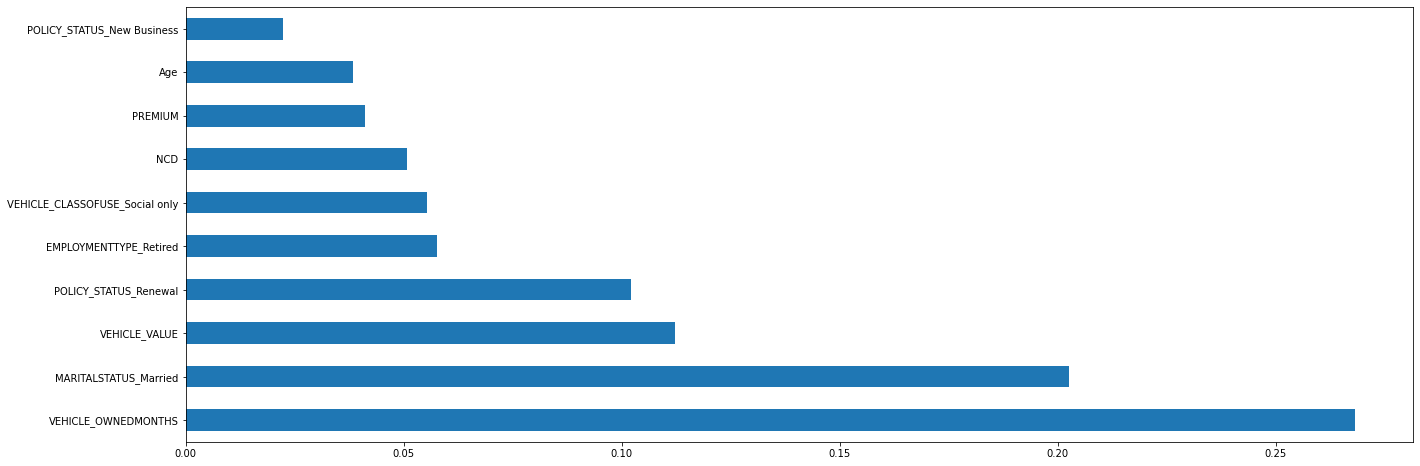

In [30]:
plt.rcParams["figure.figsize"] = (22,8)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

Display feature importance for all the features. More than half the features seem to not have contributed anything.

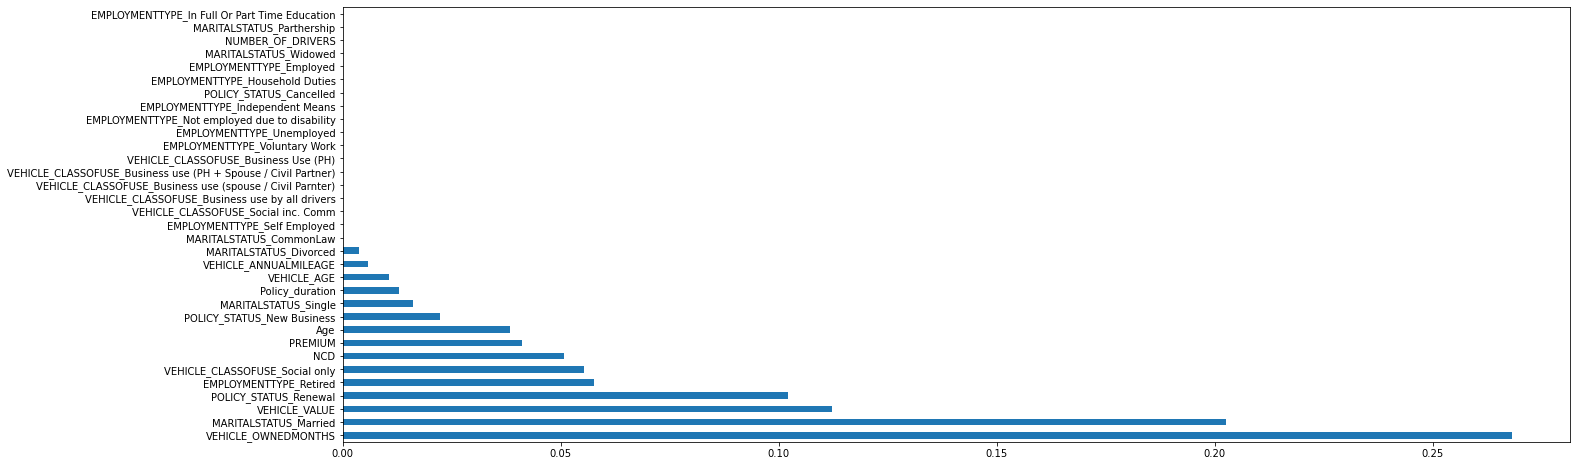

In [31]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(33).plot(kind='barh')

## Metric evaluation
The metrics used are:
* Zero-one loss (average)
* Hamming loss (average) and per segment
* Exact match ratio per segment
* Multilabel confusion matrix
* Predicted probabilities

**Zero-one loss**

Zero-one loss returns the fraction of misclassifications. The best performance is 0. In multilabel classification, the `zero_one_loss()` function corresponds to the subset zero-one loss: for each sample, the entire set of labels must be correctly predicted, otherwise the loss for that sample is equal to one.

In [32]:
# Compute the zero-one classification loss
zero_one_loss(y_test, y_pred)

0.2505556790397866

**Hamming loss**

The Hamming loss is the fraction of labels that are incorrectly predicted. In multilabel classification, the Hamming loss is different from the subset zero-one loss. The zero-one loss considers the entire set of labels for a given sample incorrect if it does not entirely match the true set of labels. Hamming loss is more forgiving in that it penalizes only the individual labels. It is always between 0 and 1, lower being better.

In [33]:
# Compute the average Hamming loss
hamming_loss(y_test, y_pred)

0.0470474920352671

**Exact Match Ratio and Hamming Loss for each segment using OneVsRestClassifier as a wrapper class**

With the use of model pipeline, decompose this multi-label task into multiple independent binary classification problems (one per category). Using "one vs rest" strategy, build multiple independent classifiers and, for each unseen instance, display the desired metrics.

In [34]:
# Using pipeline to apply decision tree classifier with one vs rest classifier as a wrapper
dt_pipeline = Pipeline([('clf', OneVsRestClassifier(clf, n_jobs=-1))])

# Loop over each segment
for category in y_train.columns:
    print('{}:'.format(category))
    
    # Fit the model to the data
    dt_pipeline.fit(X_train, y_train[category])
    
    # Calculate and display metrics
    dt_pred = dt_pipeline.predict(X_test)

    print('Exact Match Ratio: {}'.format(accuracy_score(y_test[category], dt_pred)))
    print('Hamming Loss: {}\n'.format(hamming_loss(y_test[category], dt_pred)))

SEGMENT_1_FLAG:
Exact Match Ratio: 0.8954767726161369
Hamming Loss: 0.10452322738386308

SEGMENT_2_FLAG:
Exact Match Ratio: 0.9695487886196933
Hamming Loss: 0.030451211380306736

SEGMENT_3_FLAG:
Exact Match Ratio: 0.98421871527006
Hamming Loss: 0.015781284729939987

SEGMENT_4_FLAG:
Exact Match Ratio: 0.9848299622138253
Hamming Loss: 0.015170037786174706

SEGMENT_5_FLAG:
Exact Match Ratio: 0.957101578128473
Hamming Loss: 0.04289842187152701

SEGMENT_6_FLAG:
Exact Match Ratio: 0.9265947988441876
Hamming Loss: 0.07340520115581241



### Confusion matrix

Display a multi-label confusion matrix as the model seems to suffer from overfitting when the metrics are computed individually for each segment.

In [35]:
# Use Multi-Output Classifier wrapper with Decision Tree Classifier to get predictions
clfr = MultiOutputClassifier(dtc)
clfr.fit(X_train, y_train)
pred = clfr.predict(X_test)

# Compute and display the multi-label confusion matrix
multilabel_confusion_matrix(y_test, pred)

array([[[15019,  1095],
        [  935,   947]],

       [[16932,   516],
        [  451,    97]],

       [[17413,   299],
        [  238,    46]],

       [[17516,   207],
        [  152,   121]],

       [[16488,   736],
        [  625,   147]],

       [[15638,  1037],
        [  842,   479]]])

### Predicted probabilities

Display the probability of a customer belonging to each segment and compare the results with the ground truth.

In [36]:
# Use One vs Rest Classifier wrapper with Decision Tree Classifier to get predicted probabilities for each segment
clf_prob = OneVsRestClassifier(clf)
clf_prob.fit(X_train, y_train)
prob = clf_prob.predict_proba(X_test)
prob

array([[1.02616727e-02, 4.82846252e-03, 2.51694095e-02, 0.00000000e+00,
        2.17272104e-01, 3.41064526e-01],
       [2.02447731e-01, 1.51553423e-02, 2.57756563e-02, 2.76803119e-01,
        0.00000000e+00, 1.20528771e-02],
       [5.84022039e-02, 3.31142255e-02, 0.00000000e+00, 3.25203252e-04,
        1.81323663e-03, 2.22353988e-03],
       ...,
       [1.53723161e-01, 2.58038904e-02, 2.74641440e-03, 7.01630050e-02,
        2.85795942e-04, 1.66181969e-03],
       [6.35593220e-03, 4.82846252e-03, 9.93640700e-04, 0.00000000e+00,
        1.61490683e-01, 3.37209302e-01],
       [3.57873211e-02, 5.47173241e-02, 2.53091981e-02, 1.59489633e-03,
        0.00000000e+00, 4.25481622e-03]])

In [37]:
# Compare the predicted probabilities with true predictions
y_test

,SEGMENT_1_FLAG,SEGMENT_2_FLAG,SEGMENT_3_FLAG,SEGMENT_4_FLAG,SEGMENT_5_FLAG,SEGMENT_6_FLAG
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
18033,0.0,0.0,0.0,0.0,0.0,0.0
18034,0.0,0.0,0.0,0.0,0.0,0.0
18035,0.0,0.0,0.0,0.0,0.0,0.0
18036,0.0,0.0,0.0,0.0,0.0,0.0


## Claim Frequency per segment

Compute Claim Frequency for each segment using the original data frame (erroneous values removed).

In [38]:
# Extract relevant columns from the initial joined data frame
cfreq = df[['CLAIM_ID', 'POLICY_NUMBER', 'SEGMENT_1_FLAG', 'SEGMENT_2_FLAG', 'SEGMENT_3_FLAG', 'SEGMENT_4_FLAG', 'SEGMENT_5_FLAG', 'SEGMENT_6_FLAG']]

# Iterate over each segment and compute their respective Claim Frequency percentages
for i in cfreq.columns[2:]:
    seg = cfreq[cfreq[i]==1]
    print("Claim Freq. for " + i[:-5] + ": {:0.2f} % \n".format(((seg['CLAIM_ID'].count()/seg['POLICY_NUMBER'].count()) * 100).round(2)))

Claim Freq. for SEGMENT_1: 13.47 % 

Claim Freq. for SEGMENT_2: 13.67 % 

Claim Freq. for SEGMENT_3: 13.80 % 

Claim Freq. for SEGMENT_4: 15.09 % 

Claim Freq. for SEGMENT_5: 11.97 % 

Claim Freq. for SEGMENT_6: 12.14 % 

